# Week 4: Measures of Association
As we have seen, evaluating the relationship between variables is at the heart of data mining. We have a number of techniques at our disposal:
1. Distance calculations like Euclidian, Manhattan, Cosine Similarity (and some others)
2. Measures of Independence like Chi Square, Covariance, and Correlation
3. Predictive Measures like Regression and ANOVA
In this notebook, we will spend most of our time on 2. Measures of Independence and on the adult dataset.

In [15]:
# We are setting up the environment with all the packages we could possibly need
# For pandas documentation, see https://pandas.pydata.org/pandas-docs/stable/api.html#dataframe
# For matplotlib documentation, see https://matplotlib.org/api/pyplot_summary.html

import numpy as np
import pandas as pd 
import math
import matplotlib.pyplot as plt
from scipy import spatial
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
#Reading in the data as adult dataframe
adult = pd.read_csv("https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/adult.data.simplified.csv")
# adult  # To verify that you have read in the dataframe, remove the # in front of adult

## 0. Cosine Similarity

Cosine similarity is the normalized dot product between two vectors. 
The dot product is the product of the Euclidean magnitudes of the two vectors
The cosine is the cosine of the angle between these two vectors. 
More information is here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [24]:
# Here is how this works on a very small example, with two made-up vectors
# Note that all the vectors MUST be numeric!

# Here are the vectors
a = np.array([1,2,3])
b = np.array([1,1,4])
 
# We can manually compute cosine similarity
dot = np.dot(a, b)  # the dot product
norma = np.linalg.norm(a)  # normalizing vector a
normb = np.linalg.norm(b)  # normalizing vector b
cos = dot / (norma * normb)  # computing the angle by dividing the dot product by the normalized vectors
 
# Or we use the cosine_similary function from sklearn.metrics
aa = a.reshape(1,3)
ba = b.reshape(1,3)
cos_lib = cosine_similarity(aa, ba)

# Now we need to convert the angle to radians to get the degrees
angle_in_radians = math.acos(cos_lib)
degrees = math.degrees(angle_in_radians)
 
print(
    dot,
    cos,
    cos_lib[0][0],
    degrees
)

15 0.9449111825230682 0.9449111825230683 19.10660535086906


In [23]:
# Here is how this works with the adult dataset

a = np.array(adult.educationyears)
b = np.array(adult.incomeUSD)

# Manually computing cosine similarity
dot = np.dot(a, b)  # the dot product
norma = np.linalg.norm(a)  # normalizing vector a
normb = np.linalg.norm(b)  # normalizing vector b
cos = dot / (norma * normb)  # computing the angle by dividing the dot product by the normalized vectors

# Now we use the cosine_similary function from sklearn.metrics
aa = a.reshape(1,32561)
ba = b.reshape(1,32561)
cos_lib = cosine_similarity(aa, ba)

# Now we need to convert the angle to radians to get the degrees
angle_in_radians = math.acos(cos_lib)
degrees = math.degrees(angle_in_radians)

print(
    dot,
    cos,
    cos_lib[0][0], 
    degrees
)

19649959299 0.8066671273202539 0.8066671273202539 36.228432779527736


In [25]:
# Here is a solution that uses the spatial package from scipy

a = np.array(adult.educationyears)
b = np.array(adult.incomeUSD)

result = 1 - spatial.distance.cosine(a, b)

# Now we need to convert the angle to radians to get the degrees
angle_in_radians = math.acos(result)
degrees = math.degrees(angle_in_radians)

print(
    result, 
    degrees
)

0.8066671273202538 36.22843277952774


## 1. Chi Square
Remember that a Chi Square test:
1. Is a hypothesis test based on categorical attributes.
2. Uses as its H0 that the two variables under investigation are independent
3. If the resulting p-value is > 0.05, both variables are independent
4. If the resulting p-value is < 0.05, both variables are dependent

We have TWO options:
1. The first, and most convenient, way is scipy.stats.chi2_contingency (documentation is here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html). chi2_contingency automatically computes the expected values from the table, so you don't have to. The entire output can be captured in 4 variables: chi square number, p-value, degrees of freedom and the array itself. chi2_contingency works with n-dimensional contingency tables. This is what we need!
2. The older, and more complicated, way is scipy.stats.chisquare (documentation is at https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.stats.chisquare.html). Quite a bit of munging/ preprocessing is required before we can use this algorithm: 
* chisquare will work only with numeric values, so we will have to transform any strings to numbers.
* chisquare will work only with a flattened 2-dimensional array, so we will have to figure out what to do here
* Other than with the chi2_contingency function we will have to calculate the expected frequencies ourselves: 
  np.outer(obs.sum(axis=1), obs.sum(axis=0)) / obs.sum()
This is why we will use option 1, chi2_contingency

In [78]:
# First, the convenient way with a single line 
# Note that pd.crosstab establishes the two-way table
# We can even use a print command to format the output:
chi2, p, dof, expected = chi2_contingency((pd.crosstab(adult.nativecountry, adult.occupation).values))
print (f'Chi-square Statistic: {chi2} ,p-value: {p}, Degrees of Freedom: {dof}')

Chi-square Statistic: 2437.2965238719535 ,p-value: 3.056006193732551e-227, Degrees of Freedom: 574


Here is the code for the more complicated scipy.stats.chisquare:
1. obs = np.array([a,b]).astype(float)
NOTE: The issue will be to set up the array correctly, since chisquare expects to see the counts, but will not accept the output from pd.crosstab.  
2. exp = np.outer(obs.sum(axis=1), obs.sum(axis=0)) / obs.sum()
NOTE: This will calculate the expected frequencies. axis=0 is columns, axis=1 is rows. It expects even dimensions, which is why it will not work with the output from pd.crosstabs
3. chi2, pvalue = scipy.stats.chisquare(obs.ravel(), exp.ravel(), ddof=sum(obs.shape)-2)
NOTE: This should return the same chi2 test statistic and p-value as before.

The obvious challenge here is to set up the array for categorical variables such that it can work with equation 2. Give it a try! There is a great example here: http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html

## 2. Covariance
Since covariance uses only numeric attributes, we can get np.cov() to work easily with educationyears and incomeUSD. For that purpose, we will use np.cov(). 
Note that, by default np.cov calculates the SAMPLE covariance. To get the POPULATION covariance, I had to set the Degrees of Freedom to 0. Or, as shown below, you can set bias to True. If you omit bias, you will calculate the SAMPLE variance.

In [85]:
# SAMPLE covariance assumes that ddof=1
np.cov([adult.educationyears],[adult.incomeUSD])[0][1]

33078.30227761131

In [84]:
# POPULATION covariance can be calculated by setting ddof=0
np.cov([adult.educationyears],[adult.incomeUSD], ddof=0)[0][1]

33078.30227761131

In [82]:
# POPULATION covariance with bias=True setting
np.cov([adult.educationyears],[adult.incomeUSD], bias=True)[0][1]

33077.286390437155

In [83]:
# SAMPLE covariance omitting bias=True setting
np.cov([adult.educationyears],[adult.incomeUSD])[0][1]

33078.30227761131

## 3. Correlation
As with Chi Square and Covariance, there are numerous ways to calculate the Pearson Correlation Coefficient. The most efficient and elegant way to do this is using the corr() function in pandas. This function can also handle multiple correlations and will, in fact, produce a table with the R-squared values. NOTE that all inputs must be numeric!

If correlation >-1 <0, then the attributes are negatively correlated (as one grows, another one falls). If correlation >0 <1, then the attributes are positively correlated (both move in the same direction).

In [99]:
# We first want to see if educationyears and incomeUSD are correlated. So, we pass both arrays into the function:
corr_edUSD = adult['educationyears'].corr(adult['incomeUSD'])
corr_edUSD

0.28974519143448324

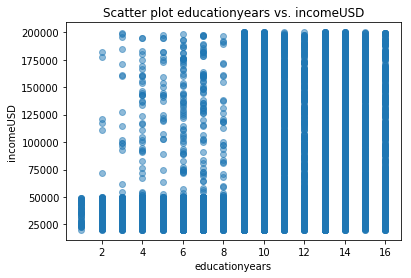

In [102]:
# We can now plot this with pyplot
plt.scatter(adult['educationyears'], adult['incomeUSD'], alpha=0.5)
plt.title('Scatter plot educationyears vs. incomeUSD')
plt.xlabel('educationyears')
plt.ylabel('incomeUSD')
plt.show()

In [93]:
# The power of the corr() function lies in its ability to handle multiple dimensions at the same time:
corr = adult.corr()
corr

,age,educationyears,hoursperweek,incomeUSD
age,1.000000,0.036527,0.068756,0.198187
educationyears,0.036527,1.000000,0.148123,0.289745
hoursperweek,0.068756,0.148123,1.000000,0.201811
incomeUSD,0.198187,0.289745,0.201811,1.000000


In [ ]:
# Now we can make a pretty correlation heatmap with pyplot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
plt.show()

In the examples above, we see the most frequently used Pearson Correlation in action. The corr() function allows us to work with other kinds of correlations, as well, including the Spearman correlation. 
For some great examples, take a look at this website: https://www.datascience.com/learn-data-science/fundamentals/introduction-to-correlation-python-data-science